In [49]:
import torch
import argparse
import csv   
import datetime

import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
from validationUtils import *
from plotUtils import *
from TUutils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [50]:
df = pd.read_csv('Logs/wgangp-2019-11-28_114731.csv', header=None)
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data)
data = data.drop(['HomeAdrMunCode'], axis=1)
data_oh = encode_onehot(data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)


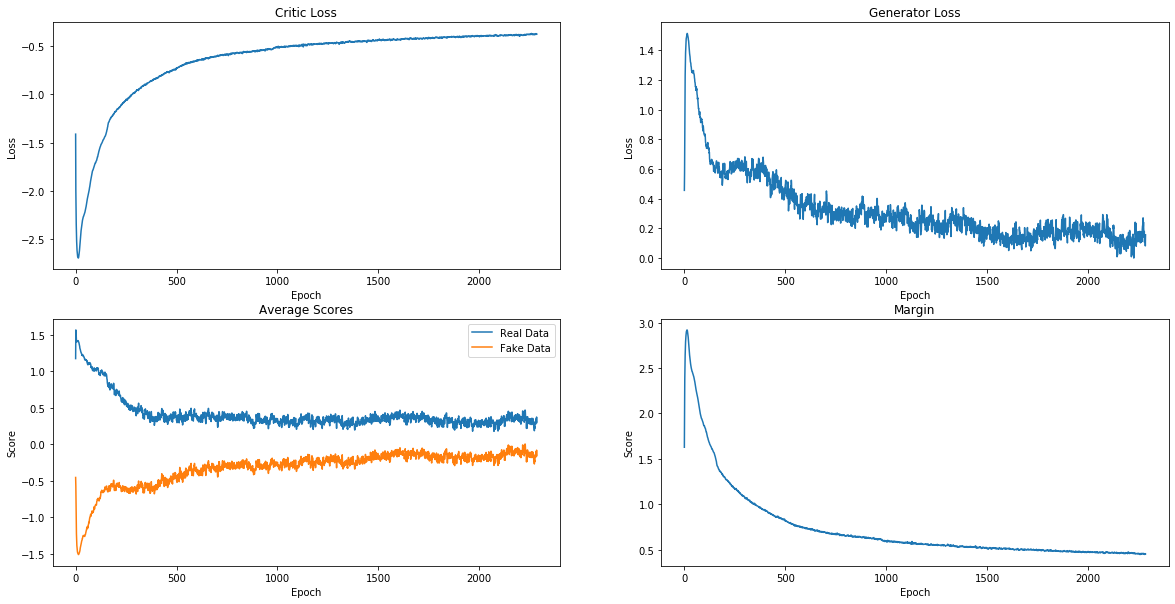

In [51]:
# Creates four polar axes, and accesses them through the returned array
df = pd.read_csv('Logs/wgangp-2019-11-30_130226.csv', header=None)

## Logs/wgangp-2019-11-28_114731.csv - good 
## Logs/wgangp-2019-11-30_105956 + converged too fast

fig, axes = plt.subplots(2, 2, figsize=(20,10))

axes[0, 0].plot(df[1])
axes[0, 0].set_title('Critic Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 1].plot(df[2])
axes[0, 1].set_title('Generator Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')

axes[1, 0].plot(df[3])
axes[1, 0].plot(df[4])
axes[1, 0].legend(['Real Data', 'Fake Data'])
axes[1, 0].set_title('Average Scores')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(df[3] - df[4])
axes[1, 1].set_title('Margin')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xlabel('Epoch')


plt.show()
fig.savefig('Figs/1.png')

In [19]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

INPUT_SIZE = 100
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [23]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out

G = torch.load('Logs/wgangp-2019-11-30_130226')

In [24]:
G = G.to(device)
z = gen_noise(INPUT_SIZE, 100000).to(device)

In [25]:
output = G.forward(z)
output = output.cpu().detach().numpy()
output = output.astype(int)

In [26]:
fake_oh = pd.DataFrame(output, columns=data_oh.columns)
fake_oh.head()
fake = back_from_dummies(fake_oh)
fake.head()

,HomeAdrNUTS,RespSex,RespPrimOcc,RespEdulevel,RespHasBicycle,RespHasSeasonticket,ResphasDrivlic,Handicap,HousehAccomodation,PosInFamily,...,HousehAccOwnorRent,HousehCarOwnership,RespAgeCorrect,RespDrivlicYear,HousehNumcars,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
0,13,1,370,3,2,2,1,2,3,11,...,2,1,"(0.0228, 0.0261]","(0.71132, 0.72137]","(0.000361, 0.000363]","(0.000721, 0.000725]","(0.000721, 0.000725]","(0.000722, 0.000726]","(0.000723, 0.00102]","(0.000721, 0.000726]"
1,32,1,210,11,1,2,1,2,1,20,...,1,1,"(0.0228, 0.0261]","(-0.00049775, 0.71018]","(0.000358, 0.000361]","(0.002, 0.0142]","(0.00107, 0.00556]","(0.00179, 0.00752]","(0.002, 0.00752]","(0.001, 0.00451]"
2,21,1,210,14,1,1,1,2,4,10,...,1,1,"(0.0124, 0.015]","(0.71025, 0.71037]","(0.000356, 0.000358]","(-0.000648, 0.000363]","(-0.001, 0.000361]","(0.00071, 0.000716]","(0.000362, 0.000711]","(-0.001, 0.000357]"
3,31,2,210,13,1,2,1,2,2,10,...,1,1,"(0.0124, 0.015]","(0.71058, 0.71132]","(0.000356, 0.000358]","(0.00142, 0.00149]","(-0.001, 0.000361]","(0.00071, 0.000716]","(0.000711, 0.000719]","(0.000357, 0.000363]"
4,42,1,210,11,2,2,1,2,4,10,...,1,1,"(0.0202, 0.0228]","(0.71037, 0.71058]","(0.000358, 0.000361]","(-0.000648, 0.000363]","(-0.001, 0.000361]","(-0.001, 0.000362]","(-0.001, 0.000362]","(0.000357, 0.000363]"


In [27]:
data.columns

Index(['HomeAdrNUTS', 'RespSex', 'RespPrimOcc', 'RespEdulevel',
       'RespHasBicycle', 'RespHasSeasonticket', 'ResphasDrivlic', 'Handicap',
       'HousehAccomodation', 'PosInFamily', 'NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic'],
      dtype='object')

In [28]:
data = data.astype('category')
fake = fake.astype('category')

MAE:4.302910520592929e-05, MSE:8.015860813807761e-08, RMSE:0.00028312295586560554, SRSME:0.018831401498636668
corr = 0.993873
MAE = 0.000109
RMSE = 0.000450
SRMSE = 0.788674
r2 = 0.987783


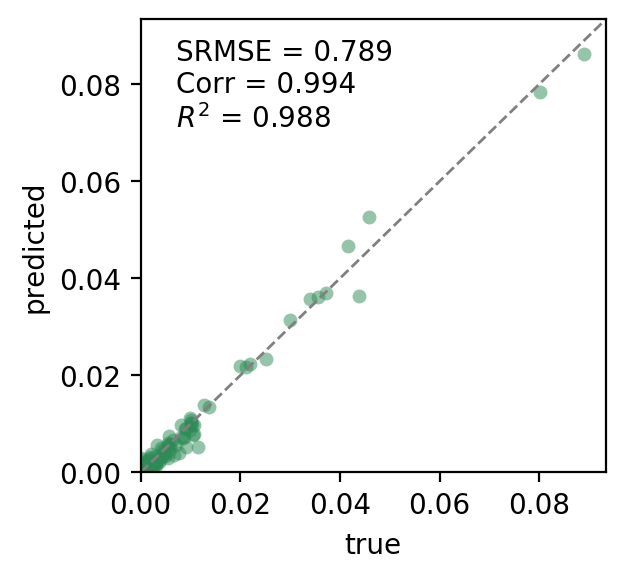

count_real  count_sampled      diff
RespSex RespPrimOcc RespEdulevel                                     
2       107         1               0.041533        0.04657 -0.005037
                    9               0.000036        0.00011 -0.000074
                    5               0.000024        0.00069 -0.000666
                    4               0.000496        0.00156 -0.001064
                    3               0.005955        0.00579  0.000165
...                                      ...            ...       ...
        169         1               0.000000        0.00001 -0.000010
        159         3               0.000000        0.00001 -0.000010
                    9               0.000000        0.00001 -0.000010
        240         12              0.000000        0.00001 -0.000010
                    5               0.000000        0.00001 -0.000010

[1754 rows x 3 columns]

In [30]:
evaluate(data, fake,  ['RespSex', 'RespPrimOcc', 'RespEdulevel'], data.columns, data, data)

MAE:0.00024333216841748267, MSE:3.5436880290657916e-07, RMSE:0.0005952888398975569, SRSME:0.01579479779060915
corr = 0.987135
MAE = 0.000388
RMSE = 0.000751
SRMSE = 0.332067
r2 = 0.971440


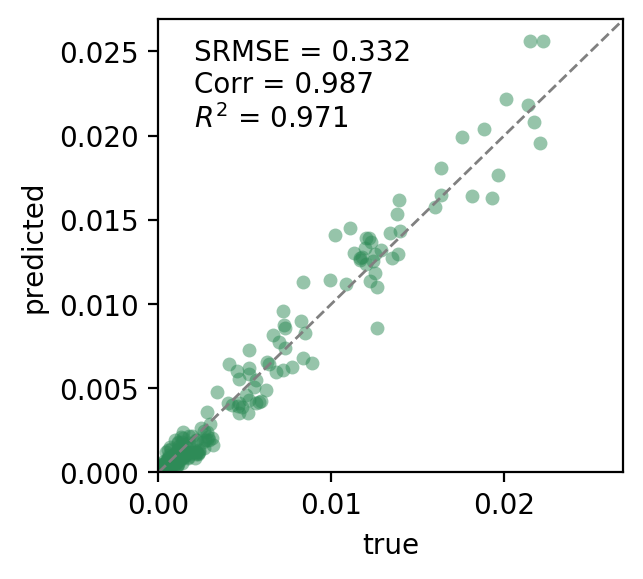

count_real  count_sampled  \
HomeAdrNUTS NuclFamType RespSex ResphasDrivlic                              
42          21          2       -18               0.008466        0.00828   
                                1                 0.022091        0.01954   
                                2                 0.001746        0.00217   
                                3                 0.000018        0.00002   
                        1       -18               0.008884        0.00650   
...                                                    ...            ...   
14          20          1       -17               0.000000        0.00001   
                        2       -18               0.000000        0.00001   
            21          1       -5                0.000000        0.00001   
                        2       3                 0.000000        0.00001   
            10          1       -17               0.000000        0.00001   

                                                    diff  
HomeAdrNUTS NuclFamType RespSex ResphasDrivlic            
42          21          2       -18             0.000186  
                                1               0.002551  
                                2              -0.000424  
                                3              -0.000002  
                        1       -18             0.002384  
...                                                  ...  
14          20          1       -17            -0.000010  
                        2       -18            -0.000010  
            21          1       -5             -0.000010  
                        2       3              -0.000010  
            10          1       -17            -0.000010  

[442 rows x 3 columns]

In [29]:
evaluate(data, fake,  ['HomeAdrNUTS', 'NuclFamType','RespSex', 'ResphasDrivlic'], data.columns, data, data)

In [47]:
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)


In [48]:
data.astype('category').describe()

,HomeAdrNUTS,HomeAdrMunCode,RespSex,RespPrimOcc,RespEdulevel,RespHasBicycle,RespHasSeasonticket,ResphasDrivlic,Handicap,HousehAccomodation,...,HousehAccOwnorRent,HousehCarOwnership,RespAgeCorrect,RespDrivlicYear,HousehNumcars,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
count,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264,...,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264
unique,11,99,2,158,14,2,2,8,2,6,...,3,14,9,9,8,9,9,9,9,9
top,42,101,2,210,11,1,2,1,2,1,...,1,1,"(0.0124, 0.015]","(-0.00053122, -0.00050148]","(-0.001, 0.000356]","(0.000714, 0.000721]","(0.000717, 0.000721]","(0.000716, 0.000722]","(0.000719, 0.000723]","(0.000717, 0.000721]"
freq,25077,13932,85845,74938,37038,119457,141612,125164,157193,92525,...,118257,93419,18589,18613,37171,18607,18597,18605,18614,18600
